In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
iglm_fn = 'data/unguided_cdr/iglm/iglm_fixed_samples_labeled_hcdr1.csv'
iglm_data = pd.read_csv(iglm_fn)['seq_recovery'].values

nosc_fn = 'data/unguided_cdr/gaussian/gaussian_fixed_length=True_samples_labeled_hcdr1.csv'
nosc_data = pd.read_csv(nosc_fn)['seq_recovery'].values

nosd_fn = 'data/unguided_cdr/mlm/mlm_fixed_length=True_samples_labeled_hcdr1.csv'
nosd_data = pd.read_csv(nosd_fn)['seq_recovery'].values

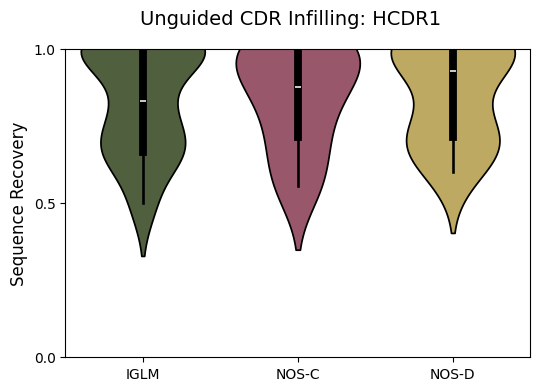

In [21]:
data_violin = {
    'IGLM': iglm_data,
    'NOS-C': nosc_data,
    'NOS-D': nosd_data
}

fig, axes = plt.subplots(1, 1, figsize=(6, 4))

group_names = []
values = []
for group, samples in data_violin.items():
    group_names.extend([group] * len(samples))
    values.extend(samples)

df_v = pd.DataFrame({"Algorithm": group_names, "Sequence Recovery": values})
sns.violinplot(x='Algorithm', y='Sequence Recovery', data=df_v, inner='box', palette=['#506538', '#A44C68', '#CCB252'], hue='Algorithm', linecolor='black', ax=axes)
axes.set_ylim(top=1)
axes.set_xlabel('')
axes.set_ylabel('Sequence Recovery', fontsize=12)
axes.tick_params(axis='both', which='major', labelsize=10)
axes.set_yticks(np.linspace(0, 1, 3))

fig.suptitle('Unguided CDR Infilling: HCDR1', fontsize=14)

plt.show()


In [22]:
from itertools import product

######## NOS ########
lambda_params = [10.0, 1.0, 0.1, 0.01, 0.001]
mu_params = [1.0]
K_params = [10]
order_params = ['first']
return_best_params = [True]
nos_params = ["mlm", "gaussian"]
nos_to_df = {
    "mlm" : pd.read_csv('data/guided_cdr/mlm/combined_samples_labeled.csv'),
    "gaussian" : pd.read_csv('data/guided_cdr/gaussian/combined_samples_labeled.csv')
}
combos = list(product(lambda_params, mu_params, K_params, order_params, return_best_params))

nosd_ll = []
nosc_ll = []
nosd_beta_sheet = []
nosc_beta_sheet = []
data_map = {
    "mlm_ll" : nosd_ll,
    "gaussian_ll": nosc_ll,

    "mlm_beta_sheet": nosd_beta_sheet,
    "gaussian_beta_sheet": nosc_beta_sheet
}

for nos in nos_params:
    df = nos_to_df[nos]
    for _, d in df.iterrows():
        for lam, mu, K, order, return_best in combos:
            valid = (d['guidance_stability_coef'] == lam) and   \
                    (d['guidance_step_size'] == mu) and         \
                    (d['guidance_num_steps'] == K) and          \
                    (d['guidance_guidance_layer'] == order) and \
                    (d['guidance_return_best'] == return_best)
            if valid:
                data_map[nos + "_ll"].append(float(-d['lm_nll'])) # ProtGPT Log Likelihood
                data_map[nos + "_beta_sheet"].append(float(d['ss_perc_sheet'])) # % Beta Sheets

##### PPLM-IGLM #####
lambda_params = [0.001, 0.01, 0.1, 1.0, 10.0]
mu_params = [1.1, 1.4, 1.7]
K_params = [10]
combos = list(product(lambda_params, mu_params, K_params))

pplm_ll = []
pplm_beta_sheet = []

df = pd.read_csv('data/guided_cdr/pplm/combined_samples_labeled.csv')

for lam, mu, K in combos:
    for _, d in df.iterrows():
        valid = ((f'step_size={mu}') in d['model_tag']) and       \
                ((f'stability_coef={lam}') in d['model_tag']) and \
                ((f'num_steps={K}') in d['model_tag'])
        if valid:
            pplm_ll.append(float(-d['lm_nll'])) # ProtGPT Log Likelihood
            pplm_beta_sheet.append(float(d['ss_perc_sheet'])) # % Beta Sheets

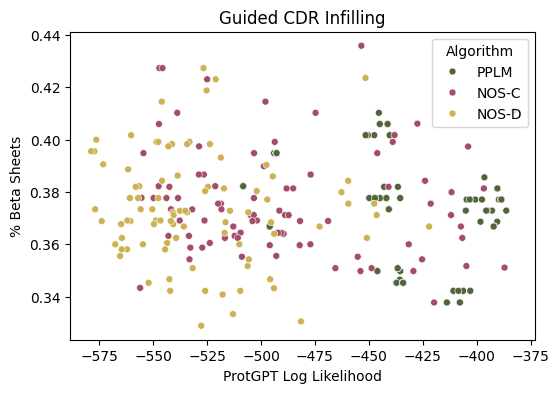

In [23]:
data = {
    "ProtGPT Log Likelihood": pplm_ll + nosc_ll + nosd_ll,
    "% Beta Sheets": pplm_beta_sheet + nosc_beta_sheet + nosd_beta_sheet,
    "Algorithm": ["PPLM"] * len(pplm_ll) + ["NOS-C"] * len(nosc_ll) + ["NOS-D"] * len(nosd_ll)
}

df = pd.DataFrame(data)

plt.figure(figsize=(6, 4))

ax = sns.scatterplot(data=df, x="ProtGPT Log Likelihood", y="% Beta Sheets", hue="Algorithm", palette=['#506538', '#A44C68', '#CCB252'], s=25)
plt.title('Guided CDR Infilling')

plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()